In [1]:
from typing import Any, Dict, List, Union, Literal

import numpy as np
import sapien
import torch

from mani_skill import ASSET_DIR
from mani_skill.agents.robots.fetch.fetch import Fetch
from mani_skill.agents.robots.panda.panda import Panda
from mani_skill.agents.robots.panda.panda_wristcam import PandaWristCam
from mani_skill.agents.robots.xmate3.xmate3 import Xmate3Robotiq
from mani_skill.envs.sapien_env import BaseEnv
from mani_skill.envs.utils.randomization.pose import random_quaternions
from mani_skill.sensors.camera import CameraConfig
from mani_skill.utils import common, sapien_utils
from mani_skill.utils.building import actors
from mani_skill.utils.io_utils import load_json
from mani_skill.utils.registration import register_env
from mani_skill.utils.scene_builder.table import TableSceneBuilder
from mani_skill.utils.structs.actor import Actor
from mani_skill.utils.structs.pose import Pose
from mani_skill.utils.structs.types import GPUMemoryConfig, SimConfig

import gymnasium as gym
import mani_skill.envs
import torch
import time

In [2]:
WARNED_ONCE = False

@register_env("ShellGamePushBall-v2", max_episode_steps=50, asset_download_ids=["ycb"])
class ShellGamePushBall(BaseEnv):

    SUPPORTED_ROBOTS = ["panda", "panda_wristcam", "fetch"]
    agent: Union[Panda, PandaWristCam, Fetch]
    goal_thresh = 0.025

    def __init__(
        self,
        *args,
        robot_uids="panda_wristcam",
        robot_init_qpos_noise=0.02,
        num_envs=1,
        reconfiguration_freq=None,
        **kwargs,
    ):
        self.robot_init_qpos_noise = robot_init_qpos_noise
        self.model_id = None
        self.all_model_ids = np.array(
            list(
                load_json(ASSET_DIR / "assets/mani_skill2_ycb/info_pick_v0.json").keys()
            )
        )
        if reconfiguration_freq is None:
            if num_envs == 1:
                reconfiguration_freq = 1
            else:
                reconfiguration_freq = 0
        super().__init__(
            *args,
            robot_uids=robot_uids,
            reconfiguration_freq=reconfiguration_freq,
            num_envs=num_envs,
            **kwargs,
        )

    @property
    def _default_sensor_configs(self):
        pose = sapien_utils.look_at(eye=[0.3, 0, 0.6], target=[-0.1, 0, 0.1])
        return [CameraConfig("base_camera", pose, 128, 128, np.pi / 2, 0.01, 100)]

    @property
    def _default_human_render_camera_configs(self):
        pose = sapien_utils.look_at([0.6, 0.7, 0.6], [0.0, 0.0, 0.15])
        return CameraConfig("render_camera", pose, 512, 512, 1, 0.01, 100)

    def _load_agent(self, options: dict):
        super()._load_agent(options, sapien.Pose(p=[-0.615, 0, 0]))

    def _load_scene(self, options: dict):
        global WARNED_ONCE
        self.table_scene = TableSceneBuilder(
            env=self, robot_init_qpos_noise=self.robot_init_qpos_noise
        )
        self.table_scene.build()

        # randomize the list of all possible models in the YCB dataset
        # then sub-scene i will load model model_ids[i % number_of_ycb_objects]
        model_ids = self._batched_episode_rng.choice(self.all_model_ids, replace=True)
        if (
            self.num_envs > 1
            and self.num_envs < len(self.all_model_ids)
            and self.reconfiguration_freq <= 0
            and not WARNED_ONCE
        ):
            WARNED_ONCE = True
            print(
                """There are less parallel environments than total available models to sample.
                Not all models will be used during interaction even after resets unless you call env.reset(options=dict(reconfigure=True))
                or set reconfiguration_freq to be >= 1."""
            )

        # TODO: "024_bowl" "025_mug" "065-a_cups" (a..j) red: 065-g_cups
        id_cup =  "025_mug"
        # ! MUG-1 INITIALIZATION
        self._objs_1: List[Actor] = []
        self.obj_heights = []
        for i, model_id in enumerate(model_ids):
            model_id = id_cup
            # print(i, model_id)
            # TODO: before official release we will finalize a metadata dataclass that these build functions should return.
            builder = actors.get_actor_builder(
                self.scene,
                id=f"ycb:{model_id}",
            )
            builder.initial_pose = sapien.Pose(p=[0, 0, 0])
            builder.set_scene_idxs([i])
            self._objs_1.append(builder.build(name=f"{model_id}-1-{i}"))
            self.remove_from_state_dict_registry(self._objs_1[-1])
        self.mug_left = Actor.merge(self._objs_1, name="mug_left")
        self.add_to_state_dict_registry(self.mug_left)

        # ! MUG-2 INITIALIZATION
        self._objs_2: List[Actor] = []
        self.obj_heights = []
        for i, model_id in enumerate(model_ids):
            model_id = id_cup
            # print(i, model_id)
            # TODO: before official release we will finalize a metadata dataclass that these build functions should return.
            builder = actors.get_actor_builder(
                self.scene,
                id=f"ycb:{model_id}",
            )
            builder.initial_pose = sapien.Pose(p=[0, 0, 0])
            builder.set_scene_idxs([i])
            self._objs_2.append(builder.build(name=f"{model_id}-2-{i}"))
            self.remove_from_state_dict_registry(self._objs_2[-1])
        self.mug_center = Actor.merge(self._objs_2, name="mug_center")
        self.add_to_state_dict_registry(self.mug_center)

        # ! MUG-1 INITIALIZATION
        self._objs_3: List[Actor] = []
        self.obj_heights = []
        for i, model_id in enumerate(model_ids):
            model_id = id_cup
            # print(i, model_id)
            # TODO: before official release we will finalize a metadata dataclass that these build functions should return.
            builder = actors.get_actor_builder(
                self.scene,
                id=f"ycb:{model_id}",
            )
            builder.initial_pose = sapien.Pose(p=[0, 0, 0])
            builder.set_scene_idxs([i])
            self._objs_3.append(builder.build(name=f"{model_id}-3-{i}"))
            self.remove_from_state_dict_registry(self._objs_3[-1])
        self.mug_right = Actor.merge(self._objs_3, name="mug_right")
        self.add_to_state_dict_registry(self.mug_right)

        self.goal_site = actors.build_cylinder(
            self.scene,
            radius=self.goal_thresh,
            half_length=self.goal_thresh,
            color=[0, 1, 0, 1],
            name="goal_site",
            body_type="kinematic",
            add_collision=False,
            initial_pose=sapien.Pose(),
        )
        self._hidden_objects.append(self.goal_site)


        # # !!!!!!!!!!!!! BALL
        self.ball_radius = 0.02
        self.red_ball = actors.build_sphere(
            self.scene,
            radius=self.ball_radius,
            color=np.array([255, 0, 0, 255]) / 255,  # Red color
            name="red_ball",
            body_type="dynamic",
            initial_pose=sapien.Pose(p=[0, 0, 0]), 
        )
        # # !!!!!!!!!!!!! BALL

    def _after_reconfigure(self, options: dict):
        self.object_zs = []
        for i, obj_group in enumerate([self._objs_1, self._objs_2, self._objs_3]):
            for obj in obj_group:
                collision_mesh = obj.get_first_collision_mesh()
                self.object_zs.append(-collision_mesh.bounding_box.bounds[0, 2])
        self.object_zs = common.to_tensor(self.object_zs, device=self.device)


    def _initialize_episode(self, env_idx: torch.Tensor, options: dict):
        with torch.device(self.device):

            self.cup_with_ball_number = self._batched_episode_rng.choice([0, 1, 2])
            self.cup_with_ball_number = torch.from_numpy(self.cup_with_ball_number).to(self.device)


            b = len(env_idx)
            self.table_scene.initialize(env_idx)

            # ! MUG-1
            xyz = torch.zeros((b, 3))
            xyz[:, :2] = torch.rand((b, 2)) * 0.2 - 0.1
            # xyz[:, 0] += 0.1 # 0.15
            xyz[:, 2] = self.object_zs[env_idx]
            q = torch.tensor([0, 1, 0.5, 0]).repeat(b, 1)

            self.min_dist = 0.2
            mug_fall_height = 0.0
            self.mug_left.set_pose(Pose.create_from_pq(p=xyz + torch.tensor([0, -self.min_dist, mug_fall_height]).repeat(b, 1), q=q))
            self.mug_center.set_pose(Pose.create_from_pq(p=xyz + torch.tensor([0, 0, mug_fall_height]), q=q))
            self.mug_right.set_pose(Pose.create_from_pq(p=xyz + torch.tensor([0, self.min_dist, mug_fall_height]).repeat(b, 1), q=q))


            # !!!!!!!!!!!!! BALL
            q = [1, 0, 0, 0]
            ball_xyz = xyz.clone()  # Create a copy of xyz for the ball
            for i in range(b):
                if self.cup_with_ball_number[i] == 0: # left
                    ball_xyz[i, :] += torch.tensor([0, -self.min_dist, self.ball_radius-self.object_zs[env_idx][i]])
                elif self.cup_with_ball_number[i] == 1: # center
                    ball_xyz[i, :] += torch.tensor([0, 0, self.ball_radius-self.object_zs[env_idx][i]])
                elif self.cup_with_ball_number[i] == 2: # right
                    ball_xyz[i, :] += torch.tensor([0, self.min_dist, self.ball_radius-self.object_zs[env_idx][i]])
            red_ball_pose = Pose.create_from_pq(p=ball_xyz, q=q)
            self.red_ball.set_pose(red_ball_pose)

            # ! GOAL
            goal_xyz = ball_xyz.clone() + torch.tensor([0.15, 0, 0])
            goal_q = torch.tensor([0.707, 0.707, 0, 0]).repeat(b, 1)
            # goal_q = torch.tensor([0.707, 0, 0.707, 0]).repeat(b, 1)  # sqrt(2)/2 ≈ 0.707
            self.goal_site.set_pose(Pose.create_from_pq(p=goal_xyz, q=goal_q))



            # Initialize robot arm to a higher position above the table than the default typically used for other table top tasks
            if self.robot_uids == "panda" or self.robot_uids == "panda_wristcam":
                # fmt: off
                qpos = np.array(
                    [0.0, 0, 0, -np.pi * 2 / 3, 0, np.pi * 2 / 3, np.pi / 4, 0.04, 0.04]
                )
                # fmt: on
                qpos[:-2] += self._episode_rng.normal(
                    0, self.robot_init_qpos_noise, len(qpos) - 2
                )
                self.agent.reset(qpos)
                self.agent.robot.set_root_pose(sapien.Pose([-0.615, 0, 0]))
            elif self.robot_uids == "xmate3_robotiq":
                qpos = np.array([0, 0.6, 0, 1.3, 0, 1.3, -1.57, 0, 0])
                qpos[:-2] += self._episode_rng.normal(
                    0, self.robot_init_qpos_noise, len(qpos) - 2
                )
                self.agent.reset(qpos)
                self.agent.robot.set_root_pose(sapien.Pose([-0.562, 0, 0]))
            else:
                raise NotImplementedError(self.robot_uids)

    def evaluate(self):
        obj_to_goal_pos = self.goal_site.pose.p - self.red_ball.pose.p
        is_obj_placed = torch.linalg.norm(obj_to_goal_pos, axis=1) <= self.goal_thresh
        is_grasped = self.agent.is_grasping(self.red_ball)
        is_robot_static = self.agent.is_static(0.2)
    
        return dict(
            is_grasped=is_grasped,
            obj_to_goal_pos=obj_to_goal_pos,
            is_obj_placed=is_obj_placed,
            is_robot_static=is_robot_static,
            is_grasping=is_grasped,
            success=torch.logical_and(is_obj_placed, is_robot_static),
        )

    def _get_obs_extra(self, info: Dict):
        # if not hasattr(self, 'original_poses'):
        self.original_poses = {
            'mug_left': self.mug_left.pose.raw_pose.clone(),
            'mug_center': self.mug_center.pose.raw_pose.clone(),
            'mug_right': self.mug_right.pose.raw_pose.clone(),
            'ball': self.red_ball.pose.raw_pose.clone(),
            'goal': self.goal_site.pose.raw_pose.clone()
        }

        TIME_OFFSET = 5 # skip 5 steps
        # Create masks for visible/hidden states
        hide_mask = info['elapsed_steps'] < TIME_OFFSET-1
        # print(info['elapsed_steps'], hide_mask)
        # show_mask = ~hide_mask

        HEIGHT_OFFSET = 100
        
        # Update poses based on masks
        for mug, orig_pose in zip(
            [self.mug_left, self.mug_center, self.mug_right],
            [self.original_poses['mug_left'], self.original_poses['mug_center'], self.original_poses['mug_right']]
        ):
            # print('before', orig_pose[:, 2])
            new_pose = orig_pose.clone()
            # if hide_mask.any():
            # print('zero', info['elapsed_steps'] == 0)
            new_pose[hide_mask & (info['elapsed_steps'] == 0), 2] += HEIGHT_OFFSET  # Move hidden mugs far away and below 150
            # print('five', info['elapsed_steps'] == TIME_OFFSET)
            new_pose[~hide_mask & (info['elapsed_steps'] == TIME_OFFSET-1), 2] -= HEIGHT_OFFSET  # Move hidden mugs far away and below 150
            # print('after', new_pose[:, 2])
            mug.pose = new_pose


        # Update ball position
        ball_pose = self.original_poses['ball'].clone()
        self.red_ball.pose = ball_pose
    
        # # Update goal position
        goal_pose = self.original_poses['goal'].clone()
        self.goal_site.pose = goal_pose




        obs = dict(
            tcp_pose=self.agent.tcp.pose.raw_pose,
            goal_pos=self.goal_site.pose.p,
            is_grasped=info["is_grasped"],
            cup_with_ball_number=self.cup_with_ball_number,
        )
        if "state" in self.obs_mode:

            obj_pose = torch.zeros_like(self.mug_left.pose.raw_pose, 
                                        device=self.mug_left.pose.raw_pose.device, 
                                        dtype=self.mug_left.pose.raw_pose.dtype)
            # Create masks for each cup position
            left_mask = (self.cup_with_ball_number == 0).unsqueeze(-1)
            center_mask = (self.cup_with_ball_number == 1).unsqueeze(-1)
            right_mask = (self.cup_with_ball_number == 2).unsqueeze(-1)

            # Use masks to assign poses
            obj_pose = (self.mug_left.pose.raw_pose * left_mask + 
                        self.mug_center.pose.raw_pose * center_mask + 
                        self.mug_right.pose.raw_pose * right_mask)
            



            tcp_to_obj_pos = torch.zeros_like(self.mug_left.pose.p, 
                                              device=self.mug_left.pose.p.device, 
                                              dtype=self.mug_left.pose.p.dtype)

            # Calculate tcp_to_obj_pos using masks
            tcp_to_obj_pos = (
                (self.mug_left.pose.p - self.agent.tcp.pose.p) * left_mask +
                (self.mug_center.pose.p - self.agent.tcp.pose.p) * center_mask +
                (self.mug_right.pose.p - self.agent.tcp.pose.p) * right_mask
            )


            obj_to_goal_pos = torch.zeros_like(self.goal_site.pose.p, 
                                              device=self.goal_site.pose.p.device, 
                                              dtype=self.goal_site.pose.p.dtype)

            # Calculate obj_to_goal_pos using masks
            obj_to_goal_pos = (
                (self.goal_site.pose.p - self.mug_left.pose.p) * left_mask +
                (self.goal_site.pose.p - self.mug_center.pose.p) * center_mask +
                (self.goal_site.pose.p - self.mug_right.pose.p) * right_mask
            )

            obs.update(
                tcp_to_goal_pos=self.goal_site.pose.p - self.agent.tcp.pose.p,
                obj_pose=obj_pose,
                tcp_to_obj_pos=tcp_to_obj_pos,
                obj_to_goal_pos=obj_to_goal_pos,
            )
        return obs

    def compute_dense_reward(self, obs: Any, action: torch.Tensor, info: Dict):

        info['success'] *= (info['elapsed_steps'] > 5)
        tcp_to_obj_dist = torch.linalg.norm(
            self.red_ball.pose.p - self.agent.tcp.pose.p, axis=1
        )
        reaching_reward = 1 - torch.tanh(5 * tcp_to_obj_dist)
        reward = reaching_reward

        is_grasped = info["is_grasped"]
        reward += is_grasped

        obj_to_goal_dist = torch.linalg.norm(
            self.goal_site.pose.p - self.red_ball.pose.p, axis=1
        )
        place_reward = 1 - torch.tanh(5 * obj_to_goal_dist)
        reward += place_reward * is_grasped

        reward += info["is_obj_placed"] * is_grasped

        static_reward = 1 - torch.tanh(
            5 * torch.linalg.norm(self.agent.robot.get_qvel()[..., :-2], axis=1)
        )
        reward += static_reward * info["is_obj_placed"] * is_grasped

        reward[info["success"]] = 6
        return reward

    def compute_normalized_dense_reward(
        self, obs: Any, action: torch.Tensor, info: Dict
    ):
        return self.compute_dense_reward(obs=obs, action=action, info=info) / 6
    


class ColorObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)

        init_obs = self.observation(self.base_env._init_raw_obs)
        self.base_env.update_obs_space(init_obs)
    
    @property
    def base_env(self) -> BaseEnv:
        return self.env.unwrapped

    
    def observation(self, obs):
        # print(self.base_env.num_envs)
        # cup_with_ball_number = self.base_env._batched_episode_rng.choice([0, 1, 2])#, size=(self.base_env.num_envs,))
        # cup_with_ball_number = torch.from_numpy(cup_with_ball_number).to(self.base_env.device)
        
        if isinstance(obs, dict):
            obs = obs.copy()
            obs['cup_with_ball_number'] = self.cup_with_ball_number
        return obs


class InitialZeroActionWrapper(gym.ActionWrapper):
    def __init__(self, env, n_initial_steps=34):
        """
        Args:
            env: environment
            n_initial_steps: number of steps with zero actions
        """
        super().__init__(env)
        self.n_initial_steps = n_initial_steps
        self.current_steps = None
        
    def action(self, action):
        """Modifies action before sending it to the environment"""
        if self.current_steps is None or (self.current_steps < self.n_initial_steps).any():
            # Zero out actions for environments still in initial phase
            mask = (self.current_steps < self.n_initial_steps)
            modified_action = action.clone()
            modified_action[mask] = 0
            return modified_action
        return action
        
    def step(self, action):
        obs, reward, terminated, truncated, info = super().step(action)
        self.current_steps = info['elapsed_steps'].detach().cpu().numpy()
        return obs, reward, terminated, truncated, info
        
    def reset(self, **kwargs):
        """Resets the step counter"""
        obs, info = super().reset(**kwargs)
        self.current_steps = info['elapsed_steps'].detach().cpu().numpy()
        return obs, info

In [3]:
num_envs = 4
env = gym.make("ShellGamePushBall-v2", num_envs=num_envs, obs_mode="rgb")
env = ColorObservationWrapper(env)
env = InitialZeroActionWrapper(env, n_initial_steps=30)
SEED = 1
obs, _ = env.reset(seed=SEED)
print(obs['cup_with_ball_number'], obs['cup_with_ball_number'].shape)
done = False
start_time = time.time()
total_rew = 0
obs_list = []
i = 0

import copy


while not done:
    obs_list.append(copy.deepcopy(obs))
    # obs_list.append(obs)
    obs, rew, terminated, truncated, info = env.step(torch.from_numpy(env.action_space.sample()))
    done = (terminated | truncated).any()
    i += 1

obs_list.append(copy.deepcopy(obs))
# obs_list.append(obs)
N = num_envs * info["elapsed_steps"][0].item()
dt = time.time() - start_time
FPS = N / (dt)
print(f"Frames Per Second = {N} / {dt} = {FPS}, iters = {i}")

There are less parallel environments than total available models to sample.
                Not all models will be used during interaction even after resets unless you call env.reset(options=dict(reconfigure=True))
                or set reconfiguration_freq to be >= 1.


/opt/conda/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.cup_with_ball_number to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.cup_with_ball_number` for environment variables or `env.get_wrapper_attr('cup_with_ball_number')` that will search the reminding wrappers.
  logger.warn(


tensor([1, 0, 0, 2], device='cuda:0') torch.Size([4])
Frames Per Second = 200 / 5.233973264694214 = 38.211887964560454, iters = 50


dict_keys(['agent', 'extra', 'sensor_param', 'sensor_data', 'cup_with_ball_number'])
dict_keys(['base_camera', 'hand_camera'])
dict_keys(['rgb'])
torch.Size([4, 128, 128, 3])


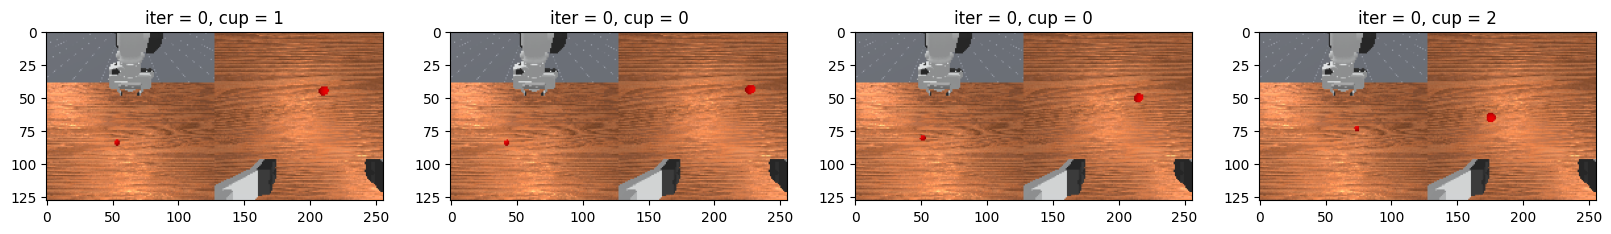

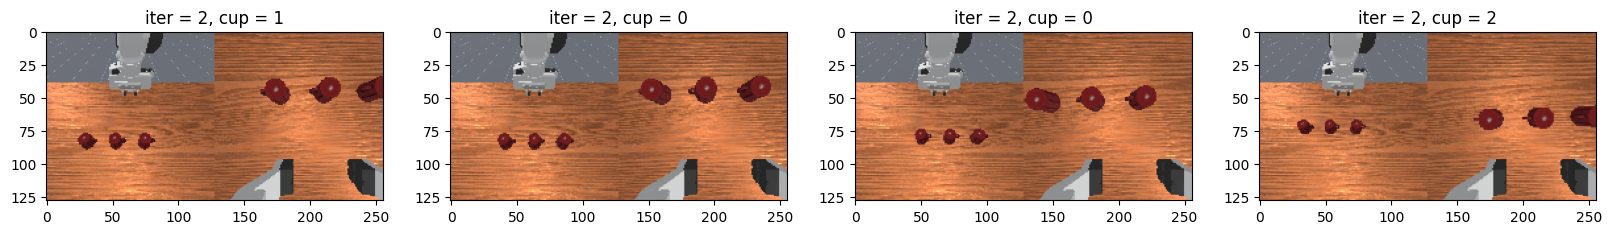

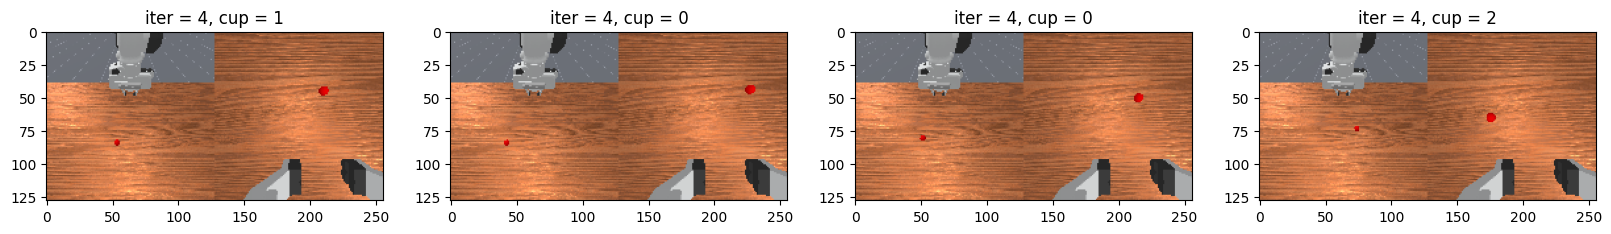

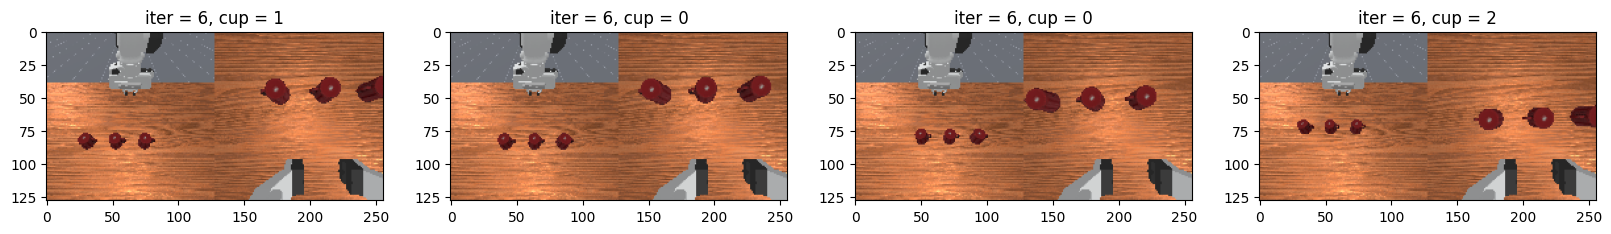

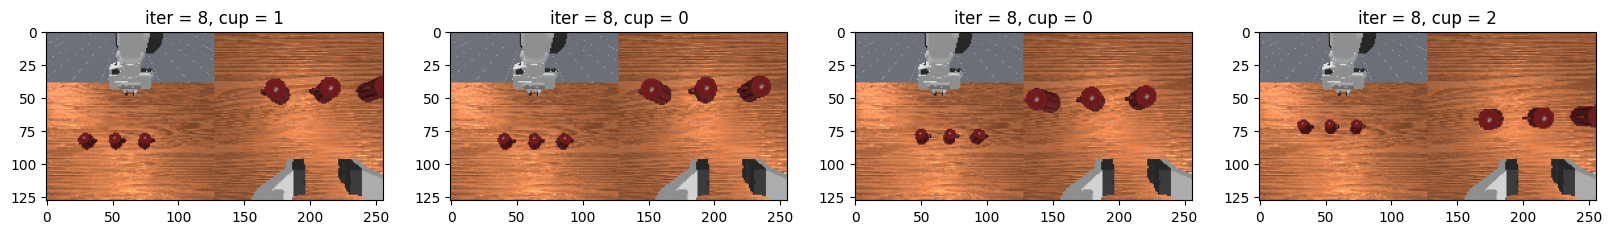

In [4]:
# visualize the image data from the environment and inspect the data
print(obs_list[0].keys())
print(obs_list[0]['sensor_data'].keys())
print(obs_list[0]['sensor_data']['base_camera'].keys())
print(obs_list[0]['sensor_data']['base_camera']['rgb'].shape)
import matplotlib.pyplot as plt

for j in range(0, 10, 2):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    for i in range(4):
        base_camera_image = obs_list[j]['sensor_data']['base_camera']['rgb'][i].cpu().numpy()
        hand_camera_image = obs_list[j]['sensor_data']['hand_camera']['rgb'][i].cpu().numpy()
        combined_image = np.concatenate((base_camera_image, hand_camera_image), axis=1)
        axs[i].imshow(combined_image)
        axs[i].set_title(f"iter = {j}, cup = {obs_list[j]['cup_with_ball_number'][i]}")
    plt.show()

In [5]:
import cv2

class RenderStepInfoWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.step_count = 0
        self.current_obs = None
        
    def reset(self, **kwargs):
        obs, info = super().reset(**kwargs)
        self.step_count = info['elapsed_steps'].detach().cpu().numpy()
        self.current_obs = obs
        return obs, info
    
    def step(self, action):
        obs, reward, terminated, truncated, info = super().step(action)
        self.current_obs = obs
        self.step_count = info['elapsed_steps'].detach().cpu().numpy()
        return obs, reward, terminated, truncated, info
    
    def render(self):
        # Get the base render from the environment
        frame = self.env.render()
        frame = frame.detach().cpu().numpy()

        # Add text
        for i in range(len(frame)):
            # Env. step
            cv2.putText(
                frame[i],
                f'Step: {self.step_count[i]}',
                (10, 30),  # position
                cv2.FONT_HERSHEY_SIMPLEX,  # font
                1.0,  # font scale
                (255, 255, 255),  # color (white)
                2,  # thickness
                cv2.LINE_AA
            )

            if self.current_obs is not None:
                if self.current_obs["cup_with_ball_number"][i] == 0:
                    cup = 'Target: Left'
                elif self.current_obs["cup_with_ball_number"][i] == 1:
                    cup = 'Target: Center'
                elif self.current_obs["cup_with_ball_number"][i] == 2:
                    cup = 'Target: Right'
                # Target cup
                cv2.putText(
                    frame[i],
                    cup,
                    (10, 60),  # position
                    cv2.FONT_HERSHEY_SIMPLEX,  # font
                    1.0,  # font scale
                    (255, 255, 255),  # color (white)
                    2,  # thickness
                    cv2.LINE_AA
                )
            
        return frame

In [6]:
# Import required packages
import gymnasium as gym
import torch
import mani_skill.envs
from tqdm.notebook import tqdm
from mani_skill.utils.wrappers import RecordEpisode
# render_mode="sensors" for real observations (rgb+d) or "rgb_array" for external camera
env = gym.make("ShellGamePushBall-v2", num_envs=num_envs, obs_mode="rgb", render_mode="rgb_array")
env = ColorObservationWrapper(env)
env = InitialZeroActionWrapper(env, n_initial_steps=30)
env = RenderStepInfoWrapper(env)  # Add our new wrapper
env = RecordEpisode(
    env,
    "./videos", # the directory to save replay videos and trajectories to
    # on GPU sim we record intervals, not by single episodes as there are multiple envs
    # each 100 steps a new video is saved
    max_steps_per_video=100
)
# from mani_skill.vector.wrappers.gymnasium import ManiSkillVectorEnv
# env = ManiSkillVectorEnv(env, num_envs=4, ignore_terminations=True, record_metrics=True)

# step through the environment with random actions
obs, _ = env.reset(seed = SEED)
for i in tqdm(range(100)):
    action = env.action_space.sample()
    # action = env.action_space.sample() * 0
    obs, reward, terminated, truncated, info = env.step(torch.from_numpy(action))
    if (terminated | truncated).any():
        break
    # env.render_human() # will render with a window if possible
env.close()
from IPython.display import Video
Video("./videos/0.mp4", embed=True, width=640) # Watch our replay

2024-11-25 19:58:34,406 - mani_skill  - WARNING - mani_skill is not installed with git.
/opt/conda/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.cup_with_ball_number to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.cup_with_ball_number` for environment variables or `env.get_wrapper_attr('cup_with_ball_number')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/100 [00:00<?, ?it/s]